# **Analyzing and Predicting AMR Staph A. Resistances with Bulk Data**

### **Objectives for this notebook**
- Collect custom test dataset, organize, and run all genes through resistance database
- Visualize and analyze data in genes
- Develop supervised and deep learning models to predict resistance genes

## **Data Collection Instructions**
---

This section details how to collect data and use an external resistance database to download additional resistance data. Most of this should be done in PC terminal rather than an IDE terminal (i.e. VS Code bash terminal). I have also linked my own data to this repository/Sharepoint for testing purposes. 

#### **Downloading data from NCBI**
1. Go to NCBI and search for [genome datasets](https://www.ncbi.nlm.nih.gov/datasets/genome/). Filter search to annotated (click sandwich menu next to "Filters") and search the particular bacteria strand you are looking for. For example, [Staph A.](https://www.ncbi.nlm.nih.gov/datasets/genome/?taxon=1280&annotated_only=true&refseq_annotation=true&genbank_annotation=true)
2. Select the amount of data you would like to collect with checkboxes and click download. If you would like to download all, select the checkbox next to "Assembly".
3. Unzip and save to a data folder (I renamed mine to "ncbi_staph50_dataset").

#### **Extracting .fna files**
1. Go to terminal by searching "cmd" or "terminal". In the terminal, access files using the cd command.

i.e.: type `cd Downloads/ncbi_staph50_dataset`

2. Make a .py file named extract_fna_files.py in this folder with the code linked below. In terminal, type `python extract_fna_files.py`.

In [ ]:
import os
import shutil

current_dir = os.path.dirname(os.path.abspath(__file__))
source_dir = os.path.join(current_dir, "ncbi_dataset", "data")
output_dir = os.path.join(current_dir, "all_fastas")

os.makedirs(output_dir, exist_ok=True)

for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith(".fna"):
            full_path = os.path.join(root, file)
            new_filename = os.path.basename(file)
            shutil.copy(full_path, os.path.join(output_dir, new_filename))

print("All .fna files copied to:", output_dir)


#### **Extracting resistance data**
*Note: These instructions use AMRFinderPlus to collect data to your environment. There are many [installation methods to work with](https://github.com/ncbi/amr/wiki/Installing-AMRFinder), but these instructions use Docker.*
1. If not already, [install Docker to device](https://www.docker.com/get-started/). Follow instructions for setup via the link.
2. Navigate to folder with your virtual environment and data.
3. Pull the docker image in your terminal/command line with `docker pull ncbi/amr`
4. Create file named "run_amr.bat" and insert code from code block below. In terminal, enter "run_amr.bat".

*Resistance data should be in "results" folder.*

In [ ]:
@echo off
setlocal enabledelayedexpansion
for %%f in (data\ncbi_staph50_dataset\all_fastas\*.fna) do (
    echo Processing file %%f
    set "file=%%f"
    set "file=!file:\=/!"
    docker run --rm -v "C:/Users/emily/Downloads/nuig-research:/app" ncbi/amr amrfinder -n /app/!file! -o /app/results/%%~nxf_amr.txt --organism Staphylococcus_aureus --plus
)
echo All files processed!


## **Data Preparation**
---

This section prepares the data into pandas dataframes for machine learning and visualization use.

In [ ]:
# Extract sequence data
import os
import pandas as pd
from Bio import SeqIO

data_folder = 'data/ncbi_staph50_dataset/all_fastas/'

base_counts = []

# Loop through each file in the directory
for filename in os.listdir(data_folder):
    if filename.endswith('.fna'):
        file_path = os.path.join(data_folder, filename)
        
        # Initialize counts for A, T, C, G
        base_count = {'file': filename, 'A': 0, 'T': 0, 'C': 0, 'G': 0, 'total_bases': 0}
        full_sequence = ''
        
        # Parse the .fna file and count base occurrences
        for record in SeqIO.parse(file_path, 'fasta'):
            seq = str(record.seq).upper()
            full_sequence += seq
            base_count['A'] += seq.count('A')
            base_count['T'] += seq.count('T')
            base_count['C'] += seq.count('C')
            base_count['G'] += seq.count('G')
            base_count['total_bases'] += len(seq)

        base_count['sequence'] = full_sequence
        
        # Calculate base ratios
        if base_count['total_bases'] > 0:
            base_count['A_ratio'] = base_count['A'] / base_count['total_bases']
            base_count['T_ratio'] = base_count['T'] / base_count['total_bases']
            base_count['C_ratio'] = base_count['C'] / base_count['total_bases']
            base_count['G_ratio'] = base_count['G'] / base_count['total_bases']
        else:
            base_count['A_ratio'] = base_count['T_ratio'] = base_count['C_ratio'] = base_count['G_ratio'] = 0
        
        base_counts.append(base_count)


df = pd.DataFrame(base_counts)
df.head()


,file,A,T,C,G,total_bases,sequence,A_ratio,T_ratio,C_ratio,G_ratio
0,GCA_000013425.1_ASM1342v1_genomic.fna,938713,955315,465832,461500,2821361,CGATTAAAGATAGAAATACACGATGCGAGCAATCAAATTTCATAAC...,0.332716,0.338601,0.165109,0.163574
1,GCA_000418345.1_ASM41834v1_genomic.fna,991460,1010093,501529,480374,2983456,GATTAAAGATAGAAATACACGATGCGAGCAATCAAATTTCATAACA...,0.332319,0.338565,0.168103,0.161013
2,GCA_000769575.1_ASM76957v1_genomic.fna,1010582,1032011,520238,483378,3046210,GATTAAAGATAGAAATACACGATGCGAGCAATCAAATTTCATAACA...,0.331751,0.338785,0.170782,0.158682
3,GCA_001027105.1_ASM102710v1_genomic.fna,934404,934422,453599,460137,2782562,ACTACTGCTCAATTTTTTTACTTTTATCGATTAAAGATAGAAATAC...,0.335807,0.335814,0.163015,0.165365
4,GCA_001515665.1_ASM151566v1_genomic.fna,998423,1007733,492038,491833,2990027,ACACGATGCGAGCAATCAAATTTCATAACATCACCATGAGTTTGAT...,0.333918,0.337031,0.164560,0.164491


In [ ]:
# Parse resistance data to dataframe
results_folder = "results/"

# Columns to keep from AMRFinderPlus output
cols_to_keep = ["Element symbol", "Class"]

# Master list for all parsed data
amr_data = []

# Parse each result file
for filename in os.listdir(results_folder):
    if filename.endswith("_amr.txt"):
        filepath = os.path.join(results_folder, filename)
        try:
            df_amr = pd.read_csv(filepath, sep="\t", dtype=str)
            df_subset = df_amr[cols_to_keep].copy()
            df_subset["file"] = filename.replace("_amr.txt", "")
            amr_data.append(df_subset)
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Combine all results
all_amr = pd.concat(amr_data, ignore_index=True)

# Drop rows with missing values
all_amr = all_amr.dropna(subset=["Element symbol", "Class"])
all_amr = all_amr.drop_duplicates()

# Group and concatenate element symbols and classes
summary = (
    all_amr.groupby("file")
    .agg({
        "Element symbol": lambda x: ", ".join(x),
        "Class": lambda x: ", ".join(x)
    })
    .reset_index()
)

df = df.merge(summary, on="file", how="left")


## **Data Visualizations**
---
Use graphs on dataframe to view patterns in gene bases in addition to resistance genes for developing ML models.

C:\Users\emily\AppData\Local\Temp\ipykernel_7504\391794511.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




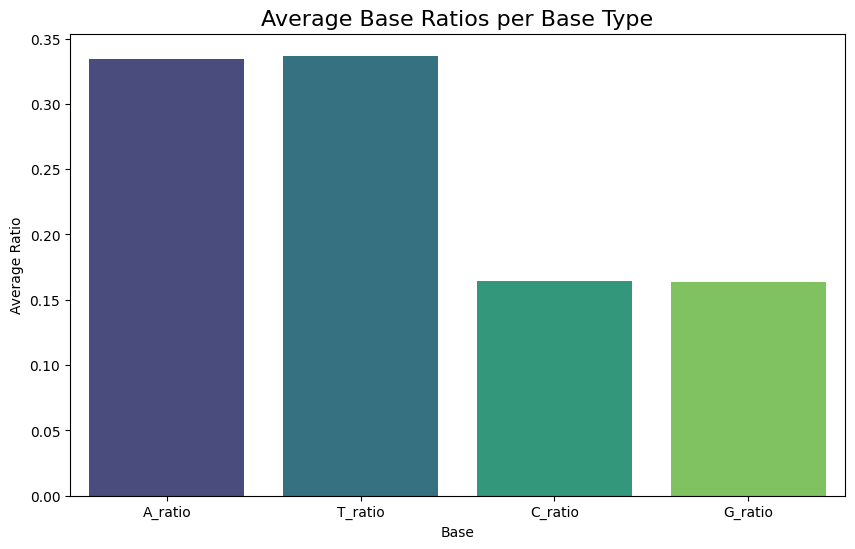

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean of the base ratios for each file
mean_ratios = df[['A_ratio', 'T_ratio', 'C_ratio', 'G_ratio']].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=mean_ratios.index, y=mean_ratios.values, palette='viridis')
plt.title('Average Base Ratios per Base Type', fontsize=16)
plt.ylabel('Average Ratio')
plt.xlabel('Base')
plt.show()


In [ ]:
# Hover to see resistance gene name
import plotly.express as px

all_amr_exploded = df.assign(**{
    'Element symbol': df['Element symbol'].str.split(', ')
}).explode('Element symbol')

# Count the occurrences of each element symbol
element_counts = all_amr_exploded['Element symbol'].value_counts().reset_index()
element_counts.columns = ['Element symbol', 'Count']

# Create interactive bar plot
fig = px.bar(
    element_counts,
    x='Element symbol',
    y='Count',
    hover_data=['Element symbol', 'Count'],
    title='Frequency of Element Symbols',
    labels={'Element symbol': 'Element Symbol', 'Count': 'Count'}
)

# Rotate x-axis labels
fig.update_layout(
    xaxis_tickangle=-90
)

fig.show()

## **Machine Learning**
---
This section details how to develop multiple supervised machine learning models and a novel feedforward network. First steps refer to data visualizations section.

#### **Filtering for resistance gene labels**
For the supervised and deep learning models, we want to narrow down the task to predicting the existance of a specific resistance gene. Refer to the graph above and select a resistance element (I selected two resistance genes to show different results.)

In [181]:
df['qacR'] = df['Element symbol'].str.contains(r'\bqacA\b', na=False)
df['qacR'] = df['qacR'].astype(int)



In [182]:
df['parE'] = df['Element symbol'].str.contains(r'\bparE_D432N\b', na=False, regex=True)
df['parE'] = df['parE'].astype(int)
print(df['parE'].value_counts())


parE
0    57
1    18
Name: count, dtype: int64


In [188]:
# Optional: Check to make sure resistance genes are filtered
filtered_df = df[(df['qacR'] == 1)]
filtered_df.head()


,file,A,T,C,G,total_bases,sequence,A_ratio,T_ratio,C_ratio,G_ratio,resistance_status,qacR,parE,Element symbol,Class
8,GCA_001641025.1_ASM164102v1_genomic.fna,1039246,1053103,512625,509302,3114278,CGATTAAAGATAGAAATACACGATGCGAGCAATCAAATTTCATAAC...,0.333704,0.338153,0.164605,0.163538,Resistant,1,0,"gyrA_S84L, ant(9)-Ia, erm(A), merT, merA, merB...","QUINOLONE, AMINOGLYCOSIDE, LINCOSAMIDE/MACROLI..."
20,GCA_026625205.1_ASM2662520v1_genomic.fna,1022551,1031215,501861,501549,3057176,ATGAACATTGAAAACTGAATGACAATATGTCAACGTTAATTCCAAA...,0.334476,0.337310,0.164158,0.164056,Resistant,1,1,"qacR, qacA, cadD, cadC, folP_E258EKE, folP_F17...","QUATERNARY AMMONIUM, QUATERNARY AMMONIUM, CADM..."
21,GCA_026625225.1_ASM2662522v1_genomic.fna,1033304,1023411,502195,502437,3061347,AAGTTAGTTGCTTCTGTTCCTCATATTCCAAACCATGTTGCTTTAT...,0.337532,0.334301,0.164044,0.164123,Resistant,1,1,"tet(38), mecI, mecR1, mecA, merB, merA, merT, ...","TETRACYCLINE, BETA-LACTAM, BETA-LACTAM, BETA-L..."
22,GCA_026625245.1_ASM2662524v1_genomic.fna,1007036,1020558,495720,493273,3016587,AATTAACTTAGTCATGAAATGGTAGGTGTAAGCATGAGAGATACAG...,0.333833,0.338315,0.164331,0.163520,Resistant,1,1,"mepA, tet(M), dfrG, folP_E258EKE, folP_F17L, p...","TETRACYCLINE, TETRACYCLINE, TRIMETHOPRIM, SULF..."
23,GCA_026625265.1_ASM2662526v1_genomic.fna,1030425,1038729,504785,505028,3078967,TGCCTGGCAACGTTCTACTCTAGCGGAACGTAAGTTCGACTACCAT...,0.334666,0.337363,0.163946,0.164025,Resistant,1,1,"cadC, qacR, qacA, cadD, lmrS, fosB, blaI, blaR...","CADMIUM/LEAD/ZINC, QUATERNARY AMMONIUM, QUATER..."


#### **Supervised learning models**
Creates a logistic regression, random forest, and extreme gradient boosting model to determine if a sequence has a specificied resistance gene based exclusively on sequence information.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Features and target
X = df['sequence']
y = df['qacR']  # Make sure this is 0 or 1 (binary labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF Vectorization (3-mers)
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr, zero_division=0))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# XG Boost
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb_model.predict(X_test_tfidf)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         9
           1       0.00      0.00      0.00         6

    accuracy                           0.60        15
   macro avg       0.30      0.50      0.38        15
weighted avg       0.36      0.60      0.45        15

Random Forest:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.67      0.80         6

    accuracy                           0.87        15
   macro avg       0.91      0.83      0.85        15
weighted avg       0.89      0.87      0.86        15

XGBoost:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.80      0.67      0.73         6

    accuracy                           0.80        15
   macro avg       0.80      0.78      0.78        15
weighted avg       0.80      

In [ ]:
# Features and target
X = df['sequence']
y = df['parE']  # Make sure this is 0 or 1 (binary labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF Vectorization (3-mers)
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr, zero_division=0))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# XG Boost
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb_model.predict(X_test_tfidf)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.00      0.00      0.00         4

    accuracy                           0.73        15
   macro avg       0.37      0.50      0.42        15
weighted avg       0.54      0.73      0.62        15

Random Forest:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.75      0.86         4

    accuracy                           0.93        15
   macro avg       0.96      0.88      0.91        15
weighted avg       0.94      0.93      0.93        15

XGBoost:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.75      0.86         4

    accuracy                           0.93        15
   macro avg       0.96      0.88      0.91        15
weighted avg       0.94      

#### **Deep Learning Models**
Develop simple feedforward models to predict if a specific resistance gene is found in a sequence.

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy import sparse

# Prepare the features and target
X_num = df[['A', 'T', 'C', 'G', 'total_bases', 'A_ratio', 'T_ratio', 'C_ratio', 'G_ratio']]
y = df['qacR']

# Normalize and vectorize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 3))
X_seq = tfidf.fit_transform(df['sequence'])
X_scaled_sparse = sparse.csr_matrix(X_scaled)
X_combined = sparse.hstack([X_scaled_sparse, X_seq])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Dense(128, input_dim=X_combined.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")


c:\Users\emily\Downloads\nuig-research\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.5208 - loss: 0.6756 - val_accuracy: 0.4667 - val_loss: 0.6456
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5875 - loss: 0.6599 - val_accuracy: 0.6667 - val_loss: 0.6213
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6194 - loss: 0.6394 - val_accuracy: 0.7333 - val_loss: 0.5999
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6201 - loss: 0.6108 - val_accuracy: 0.8000 - val_loss: 0.5802
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6097 - loss: 0.6091 - val_accuracy: 0.8000 - val_loss: 0.5615
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7069 - loss: 0.5910 - val_accuracy: 0.8000 - val_loss: 0.5455
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6410 - loss: 0.5974 - val_accuracy: 0.8000 - val_loss: 0.5319
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6535 - loss: 0.5967 - val_accuracy: 0.8000 - val_loss:

In [193]:
# Prepare the features and target
X_num = df[['A', 'T', 'C', 'G', 'total_bases', 'A_ratio', 'T_ratio', 'C_ratio', 'G_ratio']]
y = df['parE']

# Normalize and vectorize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 3))
X_seq = tfidf.fit_transform(df['sequence'])
X_scaled_sparse = sparse.csr_matrix(X_scaled)
X_combined = sparse.hstack([X_scaled_sparse, X_seq])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Dense(128, input_dim=X_combined.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")


Epoch 1/10


c:\Users\emily\Downloads\nuig-research\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.6438 - loss: 0.6478 - val_accuracy: 0.9333 - val_loss: 0.5803
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6424 - loss: 0.6267 - val_accuracy: 0.9333 - val_loss: 0.5331
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7285 - loss: 0.5919 - val_accuracy: 0.9333 - val_loss: 0.4907
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7382 - loss: 0.5582 - val_accuracy: 0.9333 - val_loss: 0.4525
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7382 - loss: 0.5442 - val_accuracy: 0.9333 - val_loss: 0.4203
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6861 - loss: 0.5543 - val_accuracy: 0.9333 - val_loss: 0.3945
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7174 - loss: 0.5174 - val_accuracy: 0.9333 - val_loss: 0.3712
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7278 - loss: 0.5294 - val_accuracy: 0.9333 - val_loss: 0.3528
Epo

43 - 0 ; 32 - 1 --> 42.67% has this gene